Primero, nos enlazamos a mi drive de Google para obtener el archivo zip de la base de fatos de las caras

In [ ]:
from google.colab import drive

# Ruta para trabajar desde drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/Datasets/img_align_celeba.zip

Mostramos un ejemplo de como se ven las imagenes

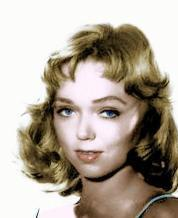

In [ ]:
from PIL import Image
from IPython.display import display

# Ruta a la imagen en tu Google Drive
ruta_imagen = '/content/img_align_celeba/202599.jpg'


# Cargar la imagen con PIL
imagen = Image.open(ruta_imagen)

# Mostrar la imagen
display(imagen)


Creamos un dataframe para manejar y acoplar las imagenes con el documento de sus etiquetas

In [ ]:
# Crear df con las propiedades necesarias
import pandas as pd

archivo_txt = '/content/drive/MyDrive/Datasets/list_attr_celeba.txt'
df1=pd.read_csv(archivo_txt, delim_whitespace=True)

print(df1.head(10))

     filename  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   
5  000006.jpg                -1                1           1               -1   
6  000007.jpg                 1               -1           1                1   
7  000008.jpg                 1                1          -1                1   
8  000009.jpg                -1                1           1               -1   
9  000010.jpg                -1               -1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -

In [ ]:
import numpy as np

columnas=np.array(df1.columns)
df1[columnas[1:]]=df1[columnas[1:]].replace({-1:0,1:1})
df1[columnas[0]]='/content/img_align_celeba/'+df1[columnas[0]]

print(df1.head(3))

                               filename  5_o_Clock_Shadow  Arched_Eyebrows  \
0  /content/img_align_celeba/000001.jpg                 0                1   
1  /content/img_align_celeba/000002.jpg                 0                0   
2  /content/img_align_celeba/000003.jpg                 0                0   

   Attractive  Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  \
0           1                0     0      0         0         0           0   
1           0                1     0      0         0         1           0   
2           0                0     0      0         1         0           0   

   ...  Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
0  ...          0        1              1          0                 1   
1  ...          0        1              0          0                 0   
2  ...          0        0              0          1                 0   

   Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Youn

In [ ]:
print(df1.iloc[:2000,0])

0       /content/img_align_celeba/000001.jpg
1       /content/img_align_celeba/000002.jpg
2       /content/img_align_celeba/000003.jpg
3       /content/img_align_celeba/000004.jpg
4       /content/img_align_celeba/000005.jpg
                        ...                 
1995    /content/img_align_celeba/001996.jpg
1996    /content/img_align_celeba/001997.jpg
1997    /content/img_align_celeba/001998.jpg
1998    /content/img_align_celeba/001999.jpg
1999    /content/img_align_celeba/002000.jpg
Name: filename, Length: 2000, dtype: object


Una vez preparados nuestros datos, los pre-procesamos usando las estructuras de datasets en tensorflow

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
ih,iw=180,180

dataconf= ImageDataGenerator(rescale=1./255, validation_split=0.4)

dataset_tr= dataconf.flow_from_dataframe(
    dataframe=df1.head(40000),
    x_col='filename',
    y_col=df1.columns[1:],
    target_size=(ih,iw),
    batch_size=100,
    class_mode='raw',
    subset='training')

dataset_vl= dataconf.flow_from_dataframe(
    dataframe=df1.head(40000),
    x_col='filename',
    y_col=df1.columns[1:],
    target_size=(ih,iw),
    batch_size=100,
    class_mode='raw',
    subset='validation')





Found 24000 validated image filenames.
Found 16000 validated image filenames.


Construimos una arquitectura de red convolucional en el que de como respuesta un vector de 40 elementos, cada uno binario, para que nos indique la cualidad que tiene una imagen conforme a las 40 caracteristicas que se anotaron para cada imagen de la base de datos.

Luego la entrenamos

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.api._v2.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint



modelf=Sequential()

modelf.add(Conv2D(64, (3, 3), input_shape=(ih, iw,3),kernel_initializer="glorot_uniform"))#,padding="valid",kernel_initializer="glorot_uniform",kernel_regularizer=L1(0.01)))
modelf.add(BatchNormalization())
modelf.add(Activation('relu'))
modelf.add(MaxPooling2D((2, 2)))

modelf.add(Conv2D(128, (3, 3),kernel_initializer="glorot_uniform"))#,padding="valid",kernel_initializer="glorot_uniform",kernel_regularizer=L1(0.01)))
modelf.add(BatchNormalization())
modelf.add(Activation('relu'))
modelf.add(MaxPooling2D(pool_size=(2, 2)))

modelf.add(Conv2D(256, (3, 3),kernel_initializer="glorot_uniform"))#,padding="valid",kernel_initializer="glorot_uniform",kernel_regularizer=L1(0.01)))
modelf.add(BatchNormalization())
modelf.add(Activation('relu'))
modelf.add(MaxPooling2D(pool_size=(2, 2)))

modelf.add(Conv2D(512, (3, 3),kernel_initializer="glorot_uniform"))#,padding="valid",kernel_initializer="glorot_uniform",kernel_regularizer=L1(0.01)))
modelf.add(BatchNormalization())
modelf.add(Activation('relu'))
modelf.add(MaxPooling2D(pool_size=(2, 2)))


modelf.add(Flatten())
modelf.add(Dense(256,activation='relu'))
modelf.add(Dense(40,activation='sigmoid'))

modelf.summary()

ruta_check= '/content/drive/MyDrive/Datasets/caras_checkpoints'
checkpoint = ModelCheckpoint(ruta_check, save_best_only=True)

opt=Adam(learning_rate=0.1)
modelf.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

earlycall=callbacks.EarlyStopping(monitor = "loss", patience = 3, mode = "auto", restore_best_weights=True)


history = modelf.fit(dataset_tr,
                     epochs=10,
                     batch_size=1000,
                     steps_per_epoch=40,
                     validation_data=dataset_vl,
                     callbacks=[checkpoint],
                     verbose=1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 178, 178, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 178, 178, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 87, 87, 128)      

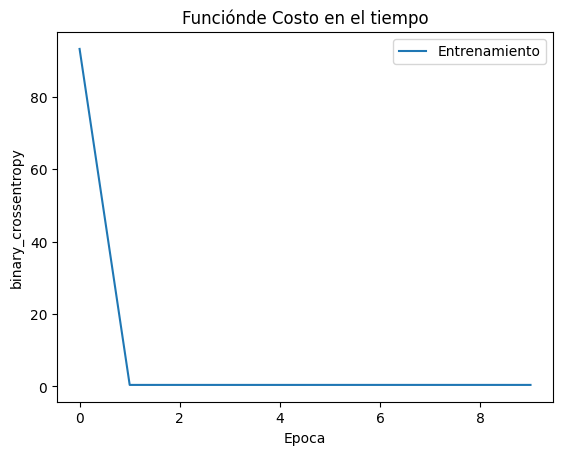

In [ ]:
import matplotlib.pyplot as plt
#graficar entrenamiento
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.plot(histdil.history['accuracy'])

plt.xlabel('Epoca')
plt.ylabel('binary_crossentropy')
plt.title('Funciónde Costo en el tiempo')
plt.legend(['Entrenamiento','Validación'])
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
a=Image.open('/content/img_align_celeba/202599.jpg').resize((180,180))
a=image.img_to_array(a)
a=preprocess_input(a.reshape(1,180,180,3))
a=modelf.predict(a)
a=a.reshape(40,)
respuestas=[round(x) for x in a]
print(respuestas)

1/1 [==============================] - 1s 1s/step
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


Ya uqedó entrenada nuestra red, con una respuest coherente